In [1]:
import datetime
import math
import numpy as np
import scipy as sp
import scipy.fftpack
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as image
from matplotlib.offsetbox import  OffsetImage

#matplotlib inline
import pyproj
import pymap3d as pm

from astropy.time import Time



In [11]:
stacode='alex'
## input data
data = pd.read_csv("data/turkeq/{}_kin03700_23.cts".format(stacode), sep=" ")

#data["dates"]
data['Lat'], data['Lon'], data['Alt'] = pm.ecef2geodetic(data['X'], data['Y'], data['Z'], ell=None, deg=True)
#data['ddate'] = pd.to_datetime(data['dates'], format='%d/%m/%Y')
#data['date'] = pd.to_datetime(data.date + data.h.astype(str),format='%d/%m/%Y %H').dt.time
#data['date']
#data['time'] =data['h'].astype(str) +':'+ data['min'].astype(str)+':'+data['sec'].astype(str)
#data['date'] = pd.to_datetime(data['ddate'].astype(str) +' '+ data['time'].astype(str))
#data['jd'] = data['mjd'] + 2400000.5

data['mjdTim'] = data['mjd']+data['sod']/(3600*24)

data['Date'] = Time(data['mjdTim'], format='mjd').datetime

#P = pyproj.Proj(proj='utm', zone=34, ellps='WGS84', preserve_units=False)
#data['utmE'], data['utmN'] = P(data['Lon'], data['Lat'])

## set index
data = data.set_index(['Date'])
data
## convert and make index to dataframwe
#time_data = "3/4/2022 12:16:25.123"
#format_data = "%d/%m/%Y"
#date = datetime.strptime(data['dates'], format_data)
#data
header= ['X','Y','Z',]
#data.to_csv('data/test_p2.txt', columns=header)
#utmout = data[['utmE', 'utmN', 'Alt']].copy()
#
#utmout
#utmout.to_csv('Outputs/utm_ts.txt')
data

,mjd,sod,X,Y,Z,Lat,Lon,Alt,mjdTim
Date,,,,,,,,,
2023-02-06 00:00:00,59981,0.0,4348024.387,2106924.037,4149806.109,40.849166,25.853456,59.826049,59981.000000
2023-02-06 00:00:01,59981,1.0,4348024.385,2106924.040,4149806.109,40.849166,25.853456,59.825677,59981.000012
2023-02-06 00:00:02,59981,2.0,4348024.387,2106924.040,4149806.108,40.849166,25.853456,59.826384,59981.000023
2023-02-06 00:00:03,59981,3.0,4348024.388,2106924.042,4149806.111,40.849166,25.853456,59.829687,59981.000035
2023-02-06 00:00:04,59981,4.0,4348024.387,2106924.042,4149806.110,40.849166,25.853456,59.828352,59981.000046
...,...,...,...,...,...,...,...,...,...
2023-02-06 21:59:55,59981,79195.0,4348024.370,2106924.027,4149806.098,40.849166,25.853456,59.803983,59981.916609
2023-02-06 21:59:56,59981,79196.0,4348024.373,2106924.027,4149806.098,40.849166,25.853456,59.806025,59981.916620
2023-02-06 21:59:57,59981,79197.0,4348024.372,2106924.029,4149806.095,40.849166,25.853456,59.804042,59981.916632


In [12]:
## convert to E N UP
meanX=data['X'].mean()
meanY=data['Y'].mean()
meanZ=data['Z'].mean()

ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
#mLon, mLat, mAlt = pyproj.transform(ecef, lla, meanX, meanY, meanZ, radians=False)
mLat, mLon, mAlt = pm.ecef2geodetic(meanX, meanY, meanZ,  ell=None, deg=True)


print(mLon, mLat, mAlt)

# mLon_r=math.radians(mLon)
# mLat_r=math.radians(mLat)
# print(meanLon, meanLat, meanAlt)

data['dX'] = data['X'] - meanX
data['dY'] = data['Y'] - meanY
data['dZ'] = data['Z'] - meanZ

## make rotational matrix
#R = [ 
#    [-math.sin(mLat_r)*math.cos(mLon_r), -math.sin(mLat_r)*math.sin(mLon_r), math.cos(mLat_r)],
#    [-math.sin(mLon_r), math.cos(mLon_r), 0],
#    [math.cos(mLat_r)*math.cos(mLon_r), math.cos(mLat_r)*math.sin(mLon_r), math.sin(mLat_r)]
#]


data['dE'], data['dN'], data['dU'] = pm.ecef2enu(data['X'], data['Y'], data['Z'], mLat, mLon, mAlt, ell=None, deg=True)
data['dN'] = data['dN']*1000.
data['dE'] = data['dE']*1000.
data['dU'] = data['dU']*1000.

#indexdN = data[ (data['dN'] >= 40) | (data['dN'] <=-40) ].index
#data.drop(indexdN , inplace=True)
header= ['X','Y','Z','dN', 'dE', 'dU']
data.to_csv('Outputs/230206_tur/smartnet/{}_enu.csv'.format(stacode), columns=header)
data

25.853456202231694 40.84916574496959 59.82154175387547


,mjd,sod,X,Y,Z,Lat,Lon,Alt,mjdTim,dX,dY,dZ,dE,dN,dU
Date,,,,,,,,,,,,,,,
2023-02-06 00:00:00,59981,0.0,4348024.387,2106924.037,4149806.109,40.849166,25.853456,59.826049,59981.000000,0.002036,0.000967,0.004284,-0.017495,1.765882,4.506877
2023-02-06 00:00:01,59981,1.0,4348024.385,2106924.040,4149806.109,40.849166,25.853456,59.825677,59981.000012,0.000036,0.003967,0.004284,3.554384,2.087431,4.135004
2023-02-06 00:00:02,59981,2.0,4348024.387,2106924.040,4149806.108,40.849166,25.853456,59.826384,59981.000023,0.002036,0.003967,0.003284,2.682242,0.153785,4.842383
2023-02-06 00:00:03,59981,3.0,4348024.388,2106924.042,4149806.111,40.849166,25.853456,59.829687,59981.000035,0.003036,0.005967,0.006284,4.045995,1.264040,8.145035
2023-02-06 00:00:04,59981,4.0,4348024.387,2106924.042,4149806.110,40.849166,25.853456,59.828352,59981.000046,0.002036,0.005967,0.005284,4.482066,1.096212,6.810241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-06 21:59:55,59981,79195.0,4348024.370,2106924.027,4149806.098,40.849166,25.853456,59.803983,59981.916609,-0.014964,-0.009033,-0.006716,-1.603413,6.303611,-17.558795
2023-02-06 21:59:56,59981,79196.0,4348024.373,2106924.027,4149806.098,40.849166,25.853456,59.806025,59981.916620,-0.011964,-0.009033,-0.006716,-2.911626,4.537795,-15.516623
2023-02-06 21:59:57,59981,79197.0,4348024.372,2106924.029,4149806.095,40.849166,25.853456,59.804042,59981.916632,-0.012964,-0.007033,-0.009716,-0.675730,2.286656,-17.499838


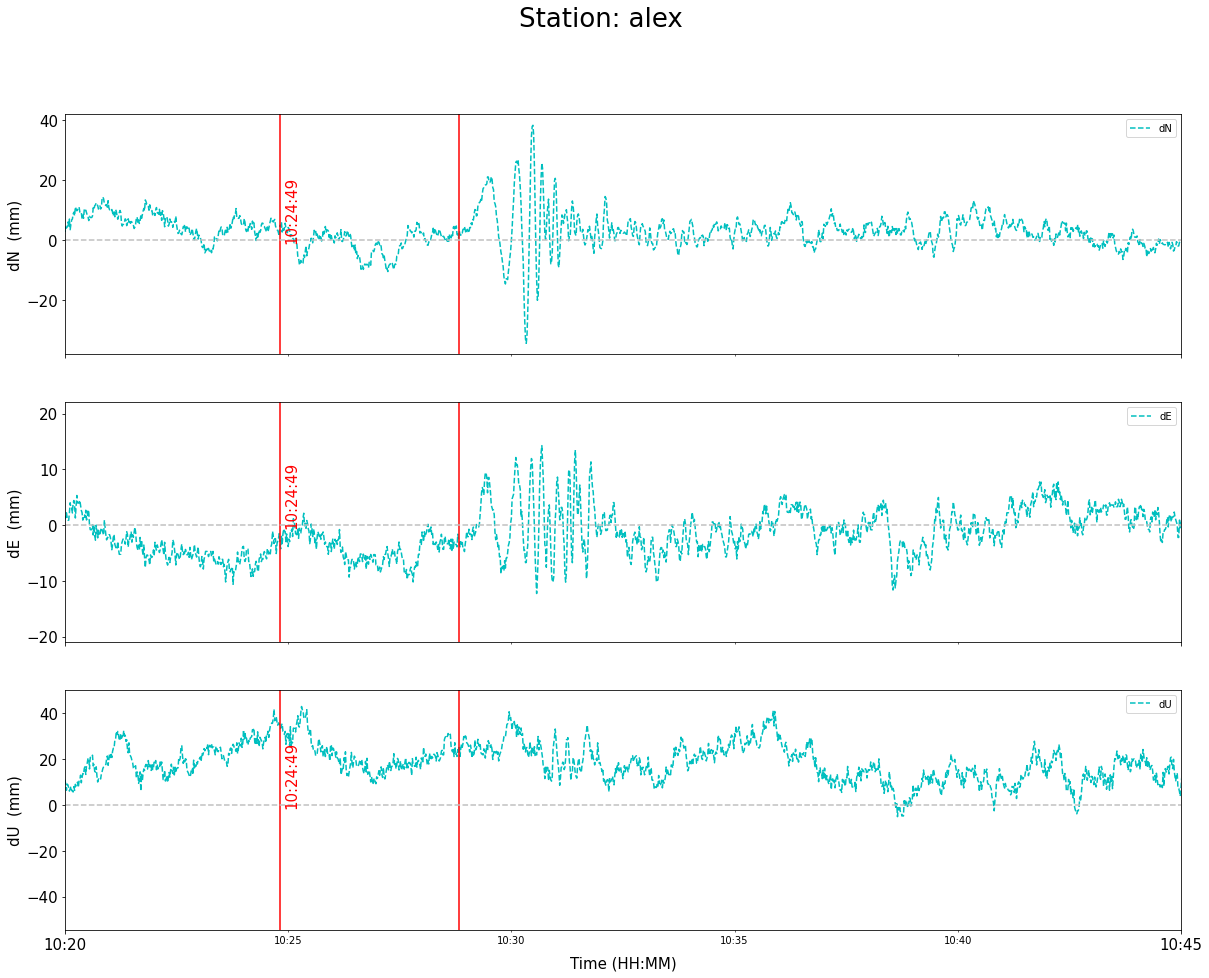

In [10]:
## make time series for the three axes
fig, axes = plt.subplots(3, 1, figsize=(20,15), sharex=True,)
fig.suptitle('Station: {} '.format(stacode), fontsize=26)


plot_cols = ['dN', 'dE', 'dU' ]
#plot_cols = ['dX', 'dY', 'dZ' ]

data[plot_cols].plot(subplots=True, ax=axes, linestyle='--', marker='', color='c')

#month_day_formatter = mdates.DateFormatter("%Y-%m-%d")
month_day_formatter = mdates.DateFormatter("%H:%M:%S")

ylimits = [[-30,30],[-20,20],[-30,30]]
#ylimits = [[-70,70],[-70,70],[-60,60]]

for i, (ax, col) in enumerate(zip(axes, plot_cols)):
    # add axis labels
    ax.set_ylabel(col + '  (mm)',fontsize=15)
    ax.set_xlabel('Time (HH:MM)', fontsize=15)
#    ax.xaxis.set_major_formatter(month_day_formatter)
#    ax.set_xlim([pd.Timestamp('2023-02-06 01:15:00'), pd.Timestamp('2023-02-06 01:35:00')])
    ax.set_xlim([pd.Timestamp('2023-02-06 10:20:00'), pd.Timestamp('2023-02-06 10:45:00')])
    #ax.set_ylim([-30,30])
#    ax.set_ylim(ylimits[i])
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=15)
    #ax.tick_params(axis='both', which='minor', labelsize=8)
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
##EVIA PERIVOLIA
    #ax.axvline(pd.Timestamp('2022-11-29 04:32:36'),color='r')
    #ax.axvline(pd.Timestamp('2022-11-29 20:06:39'),color='r')
##EVIA PSAXNA - XALKIDA
    ax.axvline(pd.Timestamp('2023-02-06 01:17:36'), color='r')
    ax.axvline(pd.Timestamp('2023-02-06 10:24:49'), color='r')
    ax.axvline(pd.Timestamp('2023-02-06 10:28:49'), color='r')
#    ax.text(pd.Timestamp('2023-02-06 01:17:40'), 0, '01:17:36', size=15, color='r', rotation=90)
    ax.text(pd.Timestamp('2023-02-06 10:24:55'), 0, '10:24:49', size=15, color='r', rotation=90)
    ax.axhline(y=0, linestyle='--', color='silver')
#    ax.axhline(y=-160, linestyle='--', color='mistyrose')
#    ax.axhline(y=120, linestyle='--', color='mistyrose')
##########0117
#    ax.axvspan(pd.Timestamp('2023-02-06 01:20:30'), pd.Timestamp('2023-02-06 01:22:50'), alpha=0.1, color='r') #ARUC
#    ax.axvspan(pd.Timestamp('2023-02-06 01:20:30'), pd.Timestamp('2023-02-06 01:22:50'), alpha=0.1, color='r') #BSHM
#    ax.axvspan(pd.Timestamp('2023-02-06 01:19:50'), pd.Timestamp('2023-02-06 01:25:20'), alpha=0.1, color='r') #NICO
#    ax.axvspan(pd.Timestamp('2023-02-06 01:23:30'), pd.Timestamp('2023-02-06 01:25:40'), alpha=0.1, color='r') #DYNG
##########1024
#    ax.axvspan(pd.Timestamp('2023-02-06 10:27:50'), pd.Timestamp('2023-02-06 10:29:30'), alpha=0.1, color='r') #ARUC
#    ax.axvspan(pd.Timestamp('2023-02-06 10:27:30'), pd.Timestamp('2023-02-06 10:29:30'), alpha=0.1, color='r') #BSHM
#    ax.axvspan(pd.Timestamp('2023-02-06 10:29:37'), pd.Timestamp('2023-02-06 10:31:00'), alpha=0.1, color='r') #NICO
#    ax.axvspan(pd.Timestamp('2023-02-06 10:26:10'), pd.Timestamp('2023-02-06 10:32:40'), alpha=0.1, color='r') #DYNG


In [13]:
## ADD LOGO+SAVE IMAGE
logo=image.imread("./logo/dso_ww_en.png")
addLogo = OffsetImage(logo, zoom=0.4)
#addLogo.set_zorder(100)
addLogo.set_offset((200,1000)) # pass the position in a tuple
ax.add_artist(addLogo)
#height = [0, 0, 0, 0, 0]
#bars = ('A', 'B', 'C', 'D', 'E')
#y = np.arange(len(bars))
#plt.bar(y, height, color=(0.2, 0.4, 0.6, 0.6))
## Save the figure
## =================================================================================
fig.savefig("Outputs/230206_tur/smartnet/{}_20230371024.jpg".format(stacode))
## =================================================================================

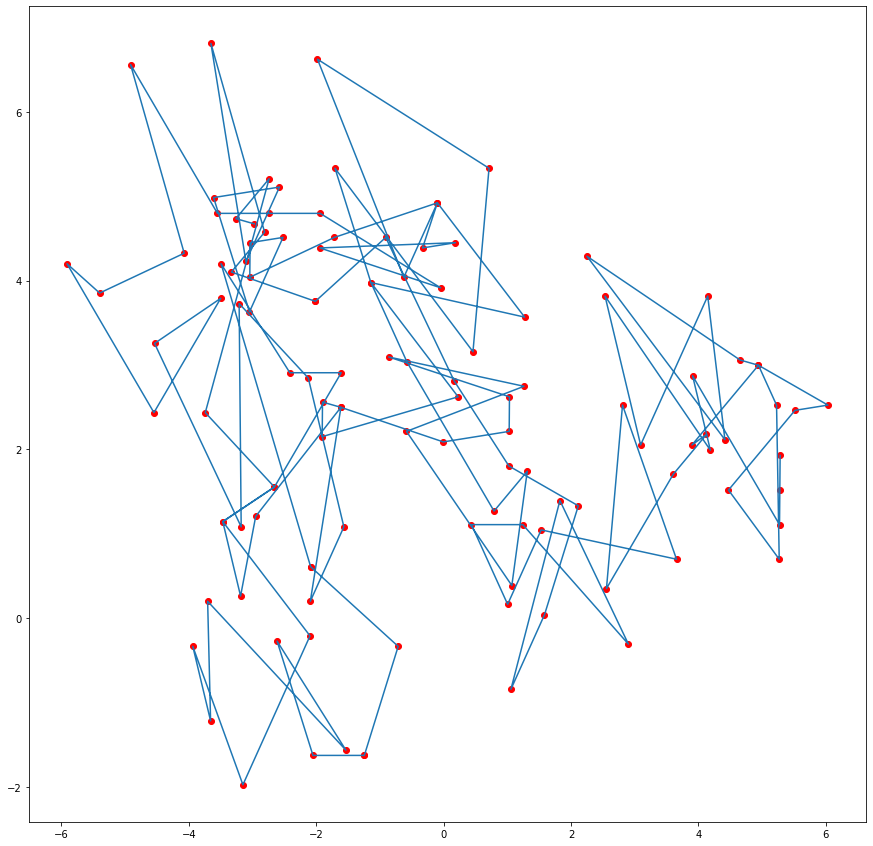

In [6]:
fig, ax = plt.subplots(figsize=(15,15))
DN=data.loc[(data.index > '2023-02-06 01:18:00') & (data.index < '2023-02-06 01:20:00'), 'dN']
DE=data.loc[(data.index > '2023-02-06 01:18:00') & (data.index < '2023-02-06 01:20:00'), 'dE']
ax.scatter(DN, DE, marker='o',linestyle='-', color='r') 
ax.plot(DN, DE, marker='',linestyle='-') 

In [7]:
#from hhpy.plotting import animplot

#animplot(data=data, x='dE', y='dN', t='sod', t_format='%S')

In [8]:
#anim.save('Outputs/230206_tur/animation.gif', writer='imagemagick', fps=60)

#data.index